In [2]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
# base_url will be empty if .env file is missi ng
assert base_url != ""
im_helper = ImageHelper(base_url)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from plantcv import plantcv as pcv
import matplotlib
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

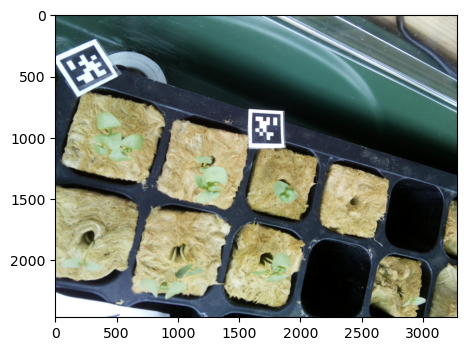

In [4]:
dt_str = '25/11/2022 17:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))

img1, path, filename = pcv.readimage(filename=im_helper.image.name)

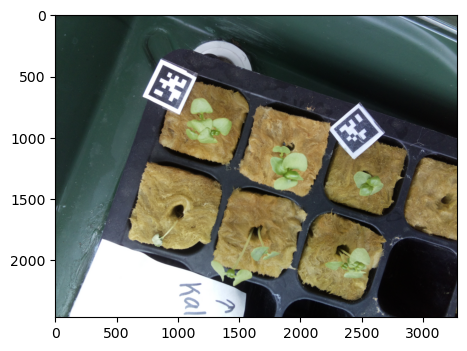

In [5]:
dt_str = '27/11/2022 17:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))

img2, path, filename = pcv.readimage(filename=im_helper.image.name)

Our goal is to be able to look at images, and normalize them to each other such that we can tell the difference in plant foliage, regardless of shots from different heights, of different croppings, from different angles. 

One approach is to use homography to map one image to another, and get the change in scale and position from the change in location of the connections between the two. In the following, we try to use homography to map one image on to another. 

In [6]:
MIN_MATCH_COUNT = 10
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [7]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h = img1.shape[0]
    w = img1.shape[1]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

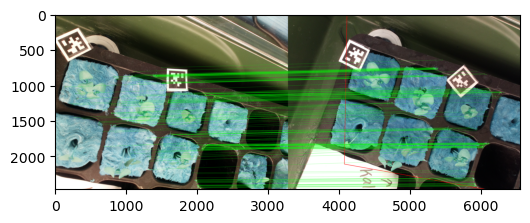

(<matplotlib.image.AxesImage at 0x7feb5bc5fac0>, None)

In [8]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3, 'gray'),plt.show()

https://pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

Running through tutorial to fix image perspective.

In [11]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [9]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

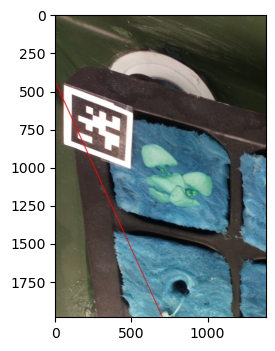

In [21]:
points = np.array([(973, 39), (93, 1817), (1975, 65), (1475, 1843)],dtype = "float32")

warp = four_point_transform(img2,points)

plt.imshow(warp)

Testing april tag code, originally pulled from Liv's code in april_tag_test.py

In [23]:
import apriltag
import argparse
import cv2

#constants
april_tag_real_size = 15.5 #mm

image = img2
image = cv2.resize(image, (image.shape[0]//2, image.shape[1]//2))
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# define the AprilTags detector options and then detect the AprilTags in the input image
print("[INFO] detecting AprilTags...")
options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)
results = detector.detect(gray)
print("[INFO] {} total AprilTags detected".format(len(results)))

# loop over the AprilTag detection results
tag_coordinates={}
for r in results:
	# extract the bounding box (x, y)-coordinates for the AprilTag
	# and convert each of the (x, y)-coordinate pairs to integers
	(ptA, ptB, ptC, ptD) = r.corners
	ptB = (int(ptB[0]), int(ptB[1]))
	ptC = (int(ptC[0]), int(ptC[1]))
	ptD = (int(ptD[0]), int(ptD[1]))
	ptA = (int(ptA[0]), int(ptA[1]))
	# draw the bounding box of the AprilTag detection
	cv2.line(image, ptA, ptB, (0, 255, 0), 2)
	cv2.line(image, ptB, ptC, (0, 255, 0), 2)
	cv2.line(image, ptC, ptD, (0, 255, 0), 2)
	cv2.line(image, ptD, ptA, (0, 255, 0), 2)
	# draw the center (x, y)-coordinates of the AprilTag
	(cX, cY) = (int(r.center[0]), int(r.center[1]))
	cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)
	# draw the tag family on the image
	tagFamily = r.tag_family.decode("utf-8")
	cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 15),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
	print("[INFO] tag family: {}".format(tagFamily))
	#find the tag id
	id = r.tag_id
	#log the tag
	tag_coordinates[id] = [cX,cY]
# show the output image after AprilTag detection
display_image = cv2.resize(image, (image.shape[0]//2, image.shape[1]//2))
cv2.imshow("Image", display_image)
print(tag_coordinates)
cv2.waitKey(0)

(1640, 1232, 3)
[INFO] detecting AprilTags...


: 

: 